## Table of Contents
- [Table of Contents](#table-of-contents)
- [1) Environment & Imports](#environment-imports)
- [5) Prepare Dataset (Load / Split / Save Originals)](#prepare-dataset-load-split-save-originals)
- [6) Generate Transforms (MEL / LOG / DWT)](#generate-transforms-mel-log-dwt)
- [7) Sanity Checks](#sanity-checks)
- [Appendix — Tips & Troubleshooting](#appendix-tips-troubleshooting)
- [2) Experiment Configuration](#experiment-configuration)
- [3) Decide Clip Length (Optional)](#decide-clip-length-optional)
- [4) Create Experiment Layout](#create-experiment-layout)
- [8) Train & Evaluate (Optional)](#train-evaluate-optional)
- [9) Metrics & Plots (Optional)](#metrics-plots-optional)

<a id="basic-example"></a>
# Basic Example

Este notebook prepara datos desde los ZIPs (`reals.zip`, `fakes.zip`), carga modelos **benchmark** de torchvision (VGG, ResNet, ALEXNET) según tu config y entrena **3 épocas** por transformación.

**Requisitos previos**:
- Carpeta del notebook: `notebooks/`
- Zips en `../dataset/` (al nivel del repo): `reals.zip`, `fakes.zip`
- (Opcional) modelos de usuario TorchScript en `../models/`

In [19]:
# 1) Rutas y pathing del proyecto (este notebook vive en notebooks/)
import sys, os
from pathlib import Path

lib_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if lib_path not in sys.path:
    sys.path.insert(0, lib_path)
print("Project root added to sys.path:", lib_path)


Project root added to sys.path: D:\UMNG-2025\FakeVoice\FakeVoice


<a id="environment-imports"></a>
## 1) Environment & Imports
<a id='sec1'></a>

**Goal:** Make sure the environment has the required packages and import the project modules.

**Requirements:**
- Python 3.9+ (recommended)
- `numpy`, `pandas`, `matplotlib`
- `librosa`, `soundfile`, `PyWavelets`
- `scikit-learn`, `torch`, `torchvision`

**Install (example):**
```bash
pip install numpy pandas matplotlib librosa soundfile PyWavelets scikit-learn torch torchvision
```
Run the next cell(s) to import `ExperimentConfig`, `CreateExperiment`, and helpers.

<a id="prepare-dataset-load-split-save-originals"></a>
## 5) Prepare Dataset (Load / Split / Save Originals)
<a id='sec5'></a>

**Goal:**
1) Read `reals.zip` and `fakes.zip`.
2) Stratified split into train/test.
3) Extract original audio files into the experiment folders.

Use:
```python
prep.load_data()
prep.split(train_ratio=0.8, seed=cfg.seed)
prep.save_original()
```
The manifest will record the **counts** of original audios for each split.

<a id="generate-transforms-mel-log-dwt"></a>
## 6) Generate Transforms (MEL / LOG / DWT)
<a id='sec6'></a>

**Goal:** Apply the selected transforms and store the features as `.npy` arrays.

- **MEL**: shape = `n_mels × n_frames` (resized to `image_size × image_size` if `cfg.image_size` is set).
- **LOG-STFT**: shape = `(1 + n_fft/2) × n_frames` (also resized if `cfg.image_size` is set).
- **DWT**: always resized to **224×224** (1 channel) for CNN/ViT compatibility.

Each transform call updates `experiment.json` with the parameters used (including `sample_rate`, `clip_seconds`, `image_size` when applicable, and the transform-specific hyperparameters).

<a id="sanity-checks"></a>
## 7) Sanity Checks
<a id='sec7'></a>

**Goal:** Verify shapes and parameters saved to the manifest.

- Load one `.npy` per class and print its shape.
- Inspect `experiment.json` parameters under `train_data.transforms_dataset[<name>].params`.

<a id="appendix-tips-troubleshooting"></a>
## Appendix — Tips & Troubleshooting
<a id='sec10'></a>

- If using ViT/ConvNeXt, prefer **224×224** inputs. Set `cfg.image_size = 224` (MEL/LOG) or use **DWT**.
- If audio files vary in length, pick an appropriate `clip_seconds`. Shorter files are zero-padded.
- If you change transform hyperparameters, rerun the transform step to regenerate features.
- Ensure CUDA is available if `cfg.device='gpu'`. Otherwise, it will fall back to CPU.
- Check `outputs/<RUN>/reports/` for figures and CSVs.

In [25]:
# 2) Imports principales
from pprint import pprint
from fakevoicefinder import ExperimentConfig, CreateExperiment, ModelLoader, Trainer, ConfigError,shortest_audio_seconds


<a id="experiment-configuration"></a>
## 2) Experiment Configuration
<a id='sec2'></a>

**Goal:** Define models, transforms, and hyperparameters.

**Key fields in `ExperimentConfig`:**
- `models_list`: e.g., `['alexnet', 'resnet18', 'convnext_tiny']`
- `transform_list`: any of `['mel', 'log', 'dwt']`
- `mel_params`, `log_params`, `dwt_params`: optional **overrides** (dicts). Defaults are used if not set.
- `clip_seconds`: window length (seconds) for each audio (pad/trim). Default is 3.0 s.
- `image_size`: **optional** resize for MEL/LOG (e.g., `224` for ViT).

Tip: Keep defaults first; only override if you need a different setting.

In [27]:
# 3) Configuración del experimento
cfg = ExperimentConfig()

# Nombre del experimento (carpeta bajo outputs/)
cfg.run_name = "exp_v1"

# Ubicaciones (repo-relativas)
cfg.data_path = "../dataset"   # donde están reals.zip y fakes.zip
cfg.models_path = "../models"  # modelos de usuario TorchScript

# Transforms a generar
cfg.transform_list = ["mel","dwt","log"]

# n_mels, n_fft, hop_length, win_length, fmin, fmax
cfg.mel_params = {
    "n_mels": 68,
    "n_fft": 2048,
    "hop_length": 512,
    # "win_length": None,
    # "fmin": 0,
    # "fmax": None,
}

# --- log: claves válidas ---
# n_fft, hop_length, win_length
cfg.log_params = {
    "n_fft": 2048,
    "hop_length": 256,
    # "win_length": None,
}

# --- dwt: claves válidas ---
# wavelet, level, mode
cfg.dwt_params = {
    "wavelet": "db6",
    "level": 5,
    "mode": "symmetric",
}

cfg.image_size = 224

# Modelos benchmark a probar
cfg.models_list = ["alexnet","resnet18","vgg16","vit_b_16","convnext_tiny"]

# Entrenamiento rápido de smoke-test
cfg.type_train = "both"   # 'scratch' | 'pretrain' | 'both'
cfg.epochs = 3
cfg.batch_size = 8
cfg.learning_rate = 0.0001
cfg.patience = 5

# Canal de entrada de los espectrogramas (.npy): 1 canal
cfg.input_channels = 1 


# Validación de la config
try:
    cfg.validate()
    print("Config validation ✅")
except ConfigError as e:
    print("Config validation error:", e)
    raise

print(cfg.summary())


Config validation ✅
ExperimentConfig:
  batch_size     : 8
  cache_features : True
  clip_seconds   : None
  data_path      : ../dataset
  device         : gpu
  dwt_params     : {'wavelet': 'db6', 'level': 5, 'mode': 'symmetric'}
  epochs         : 3
  eval_metric    : ['accuracy', 'F1']
  fakes_zip      : fakes.zip
  flag_train     : True
  image_size     : 224
  input_channels : 1
  learning_rate  : 0.0001
  log_params     : {'n_fft': 2048, 'hop_length': 256}
  mel_params     : {'n_mels': 68, 'n_fft': 2048, 'hop_length': 512}
  models_list    : ['alexnet', 'resnet18', 'vgg16', 'vit_b_16', 'convnext_tiny']
  models_path    : ../models
  num_workers    : 4
  optimizer      : Adam
  outputs_path   : outputs
  patience       : 5
  reals_zip      : reals.zip
  run_name       : exp_v1
  save_best_only : True
  save_models    : True
  seed           : 23
  transform_list : ['mel', 'dwt', 'log']
  type_train     : both


<a id="decide-clip-length-optional"></a>
## 3) Decide Clip Length (Optional)
<a id='sec3'></a>

**Goal:** Choose the time window (`clip_seconds`) to use for all audios.

Use `shortest_audio_seconds(cfg)` to scan `reals.zip` and `fakes.zip` and return the shortest duration in seconds. Then either:
- **A)** set `cfg.clip_seconds = min_duration` to avoid truncation; or
- **B)** choose a fixed value (e.g., 3.0 s). Short files will be **zero-padded** automatically.

In [29]:
# 2) Elegir la ventana de audio (clip_seconds)
min_sec = int(shortest_audio_seconds(cfg))
print(f"Duración mínima detectada en los zips: {min_sec}")

# Opción A: usar exactamente la mínima detectada
cfg.clip_seconds = min_sec

# Opción B: usar un valor fijo que tú prefieras (p. ej., 3.0 s)
# cfg.clip_seconds = 3.0

# Nota: si pones un valor mayor que muchos audios, se rellenará con padding (como ya hace el pipeline).


Duración mínima detectada en los zips: 4


<a id="create-experiment-layout"></a>
## 4) Create Experiment Layout
<a id='sec4'></a>

**Goal:** Initialize the experiment folder structure and manifest (`experiment.json`).

Run `CreateExperiment(cfg).build()` to set up:
- `outputs/<RUN>/datasets/{train,test}/...`
- `outputs/<RUN>/models/loaded/`
- `outputs/<RUN>/reports/`

The manifest stores paths and metadata for reproducibility.

In [31]:
exp = CreateExperiment(cfg, experiment_name=cfg.run_name)
exp.build()

summary = exp.prepare_data(train_ratio=0.8, seed=cfg.seed, transforms=cfg.transform_list)
print("Data prep summary:")
pprint(summary)

print("Manifest:", (exp.root / "experiment.json").as_posix())


C:\Users\Gpach\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


Data prep summary:
{'load': {'fakes': 600, 'reals': 600},
 'save_original': {'test': 240, 'train': 960},
 'split': {'test': {'fakes': 120, 'reals': 120, 'total': 240},
           'train': {'fakes': 480, 'reals': 480, 'total': 960}},
 'transforms': {'dwt': {'test': 240, 'train': 960},
                'log': {'test': 240, 'train': 960},
                'mel': {'test': 240, 'train': 960}}}
Manifest: D:/UMNG-2025/FakeVoice/FakeVoice/outputs/exp_v1/experiment.json


In [32]:
loader = ModelLoader(exp)
bench = loader.prepare_benchmarks(add_softmax=False, input_channels=getattr(cfg, "input_channels", 1))
print("Benchmarks saved under models/loaded:")
pprint(bench)

# User models (if any .pt/.pth under cfg.models_path)
user = loader.prepare_user_models(add_softmax=False, input_channels=cfg.input_channels)
print("User models saved:")
pprint(user)

Benchmarks saved under models/loaded:
{'alexnet': {'pretrain': 'outputs/exp_v1/models/loaded/alexnet_pretrain.pt',
             'scratch': 'outputs/exp_v1/models/loaded/alexnet_scratch.pt'},
 'convnext_tiny': {'pretrain': 'outputs/exp_v1/models/loaded/convnext_tiny_pretrain.pt',
                   'scratch': 'outputs/exp_v1/models/loaded/convnext_tiny_scratch.pt'},
 'resnet18': {'pretrain': 'outputs/exp_v1/models/loaded/resnet18_pretrain.pt',
              'scratch': 'outputs/exp_v1/models/loaded/resnet18_scratch.pt'},
 'vgg16': {'pretrain': 'outputs/exp_v1/models/loaded/vgg16_pretrain.pt',
           'scratch': 'outputs/exp_v1/models/loaded/vgg16_scratch.pt'},
 'vit_b_16': {'pretrain': 'outputs/exp_v1/models/loaded/vit_b_16_pretrain.pt',
              'scratch': 'outputs/exp_v1/models/loaded/vit_b_16_scratch.pt'}}
User models saved:
{'SimpleCNN_scripted.pt': 'outputs/exp_v1/models/loaded/SimpleCNN_scripted_usermodel_jit.pt'}


In [33]:
def print_tree(root: Path, max_depth: int = 3, prefix: str = ""):
    if max_depth < 0:
        return
    try:
        entries = sorted(root.iterdir(), key=lambda p: (p.is_file(), p.name.lower()))
    except FileNotFoundError:
        return
    for e in entries:
        print(prefix + ("📄 " if e.is_file() else "📁 ") + e.name)
        if e.is_dir():
            print_tree(e, max_depth - 1, prefix + "   ")

print_tree(exp.root, max_depth=3)

📁 datasets
   📁 test
      📁 original
         📁 fakes
         📁 reals
      📁 transforms
         📁 dwt
         📁 log
         📁 mel
   📁 train
      📁 original
         📁 fakes
         📁 reals
      📁 transforms
         📁 dwt
         📁 log
         📁 mel
📁 models
   📁 loaded
      📄 alexnet_pretrain.pt
      📄 alexnet_scratch.pt
      📄 convnext_tiny_pretrain.pt
      📄 convnext_tiny_scratch.pt
      📄 resnet18_pretrain.pt
      📄 resnet18_scratch.pt
      📄 SimpleCNN_scripted_usermodel_jit.pt
      📄 vgg16_pretrain.pt
      📄 vgg16_scratch.pt
      📄 vit_b_16_pretrain.pt
      📄 vit_b_16_scratch.pt
   📁 trained
📁 reports
📄 experiment.json


<a id="train-evaluate-optional"></a>
## 8) Train & Evaluate (Optional)
<a id='sec8'></a>

**Goal:** Train your selected models and compute metrics on the test split.

- Use your training loop or the provided trainer to fit each model.
- Evaluate with `MetricsReporter` to build a DataFrame of scores (Accuracy, F1).

In [35]:
trainer = Trainer(exp)
train_results = trainer.train_all()
print("Resultados de entrenamiento (rutas repo-relativas):")
pprint(train_results)

print("Best checkpoints stored in:", (exp.trained_models).as_posix())


[Trainer] Using device: cuda
[Trainer] Transforms to train: ['mel', 'dwt', 'log']
[Trainer] Models found: ['alexnet', 'resnet18', 'vgg16', 'vit_b_16', 'convnext_tiny', 'usermodel_SimpleCNN_scripted.pt']

=== MODEL: alexnet ===
[alexnet] Hyperparams -> epochs=3, lr=0.0001, bs=8, optimizer=Adam, patience=5, seed=23, num_workers=4
[alexnet][mel] Dataset sizes -> train: 960, test: 240
[alexnet][mel] Batches -> train: 120, test: 30
[alexnet][mel][scratch] Loading checkpoint: D:\UMNG-2025\FakeVoice\FakeVoice\outputs\exp_v1\models\loaded\alexnet_scratch.pt
[alexnet][mel][scratch] Loaded pickled module.
[alexnet][mel][scratch] Start training for 3 epochs
[alexnet][mel][scratch] Epoch 1/3 - loss=0.7020 acc=0.5000
[alexnet][mel][scratch] Confusion matrix (test):
[[TN=   0, FP= 120],
 [FN=   0, TP= 120]]
[alexnet][mel][scratch] ✅ New best acc=0.5000 at epoch 1
[alexnet][mel][scratch] Epoch 2/3 - loss=0.6956 acc=0.5000
[alexnet][mel][scratch] Confusion matrix (test):
[[TN= 120, FP=   0],
 [FN= 120

In [36]:
def print_tree(root: Path, max_depth: int = 3, prefix: str = ""):
    if max_depth < 0:
        return
    try:
        entries = sorted(root.iterdir(), key=lambda p: (p.is_file(), p.name.lower()))
    except FileNotFoundError:
        return
    for e in entries:
        print(prefix + ("📄 " if e.is_file() else "📁 ") + e.name)
        if e.is_dir():
            print_tree(e, max_depth - 1, prefix + "   ")

print_tree(exp.root, max_depth=3)

📁 datasets
   📁 test
      📁 original
         📁 fakes
         📁 reals
      📁 transforms
         📁 dwt
         📁 log
         📁 mel
   📁 train
      📁 original
         📁 fakes
         📁 reals
      📁 transforms
         📁 dwt
         📁 log
         📁 mel
📁 models
   📁 loaded
      📄 alexnet_pretrain.pt
      📄 alexnet_scratch.pt
      📄 convnext_tiny_pretrain.pt
      📄 convnext_tiny_scratch.pt
      📄 resnet18_pretrain.pt
      📄 resnet18_scratch.pt
      📄 SimpleCNN_scripted_usermodel_jit.pt
      📄 vgg16_pretrain.pt
      📄 vgg16_scratch.pt
      📄 vit_b_16_pretrain.pt
      📄 vit_b_16_scratch.pt
   📁 trained
      📄 alexnet_pretrain_dwt_seed23_epoch001_acc0.79.pt
      📄 alexnet_pretrain_log_seed23_epoch003_acc0.82.pt
      📄 alexnet_pretrain_mel_seed23_epoch003_acc0.79.pt
      📄 alexnet_scratch_dwt_seed23_epoch003_acc0.82.pt
      📄 alexnet_scratch_log_seed23_epoch001_acc0.51.pt
      📄 alexnet_scratch_mel_seed23_epoch001_acc0.50.pt
      📄 convnext_tiny_pretrain_dwt_seed2

<a id="metrics-plots-optional"></a>
## 9) Metrics & Plots (Optional)
<a id='sec9'></a>

**Goal:** Visualize results.

- `plot_architectures_for_transform`: bar chart of `(model+variant)` for a single transform.
- `plot_variants_for_model`: bar chart of `(transform)` for a single `(model, variant)`.
- `plot_heatmap_models_transforms`: heatmap over `(models×variants) × transforms`.

**Color map defaults:** worst value → red, better → green, max at 100%. Each cell shows its value in %.

In [38]:
from fakevoicefinder.config import ExperimentConfig
from fakevoicefinder.experiment import CreateExperiment
from fakevoicefinder.metrics import MetricsReporter

EXP_NAME = cfg.run_name  

cfg = ExperimentConfig(); cfg.run_name = EXP_NAME
exp = CreateExperiment(cfg, experiment_name=cfg.run_name)  

rep = MetricsReporter(exp)                   # toma reports/ del manifest
df = rep.evaluate_all("metrics_summary.csv") # guarda CSV en outputs/<exp>/reports/

[metrics] CSV saved -> D:\UMNG-2025\FakeVoice\FakeVoice\outputs\exp_v1\reports\metrics_summary.csv


,model,variant,transform,accuracy,f1,f1_macro,f1_micro,precision,recall,checkpoint
0,alexnet,pretrain,dwt,61.25,72.07,54.40,61.25,56.34,100.00,outputs/exp_v1/models/trained/alexnet_pretrain...
1,alexnet,scratch,dwt,82.50,82.64,82.50,82.50,81.97,83.33,outputs/exp_v1/models/trained/alexnet_scratch_...
2,convnext_tiny,pretrain,dwt,50.00,66.67,33.33,50.00,50.00,100.00,outputs/exp_v1/models/trained/convnext_tiny_pr...
3,convnext_tiny,scratch,dwt,64.17,69.50,63.03,64.17,60.49,81.67,outputs/exp_v1/models/trained/convnext_tiny_sc...
4,resnet18,pretrain,dwt,90.83,90.18,90.79,90.83,97.12,84.17,outputs/exp_v1/models/trained/resnet18_pretrai...


In [56]:
df

,model,variant,transform,accuracy,f1,f1_macro,f1_micro,precision,recall,checkpoint
0,alexnet,pretrain,dwt,61.25,72.07,54.40,61.25,56.34,100.00,outputs/exp_v1/models/trained/alexnet_pretrain...
1,alexnet,scratch,dwt,82.50,82.64,82.50,82.50,81.97,83.33,outputs/exp_v1/models/trained/alexnet_scratch_...
2,convnext_tiny,pretrain,dwt,50.00,66.67,33.33,50.00,50.00,100.00,outputs/exp_v1/models/trained/convnext_tiny_pr...
3,convnext_tiny,scratch,dwt,64.17,69.50,63.03,64.17,60.49,81.67,outputs/exp_v1/models/trained/convnext_tiny_sc...
4,resnet18,pretrain,dwt,90.83,90.18,90.79,90.83,97.12,84.17,outputs/exp_v1/models/trained/resnet18_pretrai...
5,resnet18,scratch,dwt,87.08,86.81,87.08,87.08,88.70,85.00,outputs/exp_v1/models/trained/resnet18_scratch...
6,usermodel_SimpleCNN_scripted.pt,usermodel_jit,dwt,85.42,84.72,85.39,85.42,88.99,80.83,outputs/exp_v1/models/trained/usermodel_Simple...
7,vgg16,pretrain,dwt,85.83,86.82,85.75,85.83,81.16,93.33,outputs/exp_v1/models/trained/vgg16_pretrain_d...
8,vgg16,scratch,dwt,80.83,80.99,80.83,80.83,80.33,81.67,outputs/exp_v1/models/trained/vgg16_scratch_dw...
9,vit_b_16,pretrain,dwt,58.33,70.06,50.78,58.33,54.67,97.50,outputs/exp_v1/models/trained/vit_b_16_pretrai...


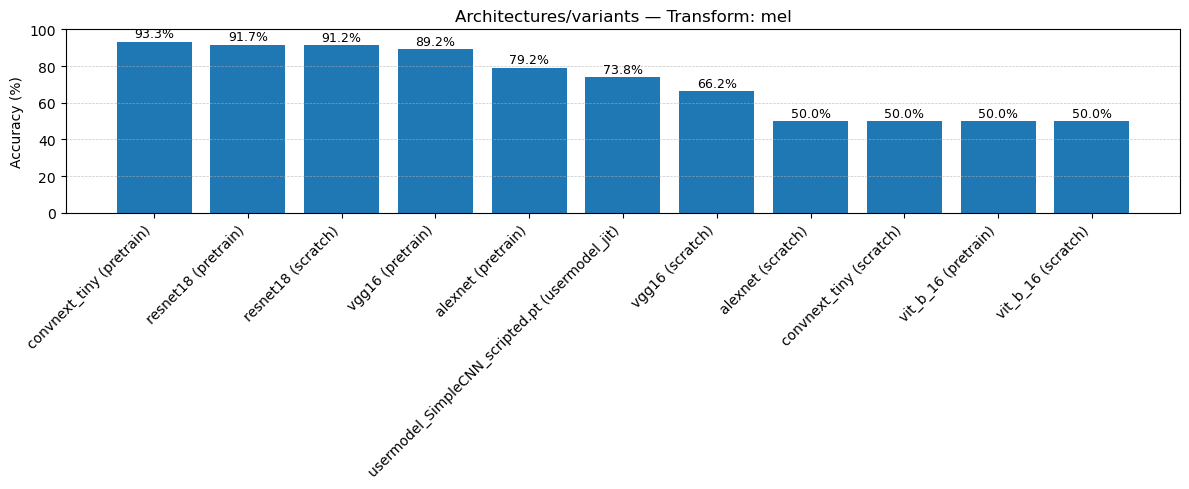

[metrics] Figure saved -> D:\UMNG-2025\FakeVoice\FakeVoice\outputs\exp_v1\reports\fig_arch_mel_acc.png


In [58]:
# Figuras (se guardan en 'reports/' al pasar out_name)
rep.plot_architectures_for_transform(df, transform="mel", metric="accuracy",
                                     y_min=0, y_max=100, out_name="fig_arch_mel_acc.png")


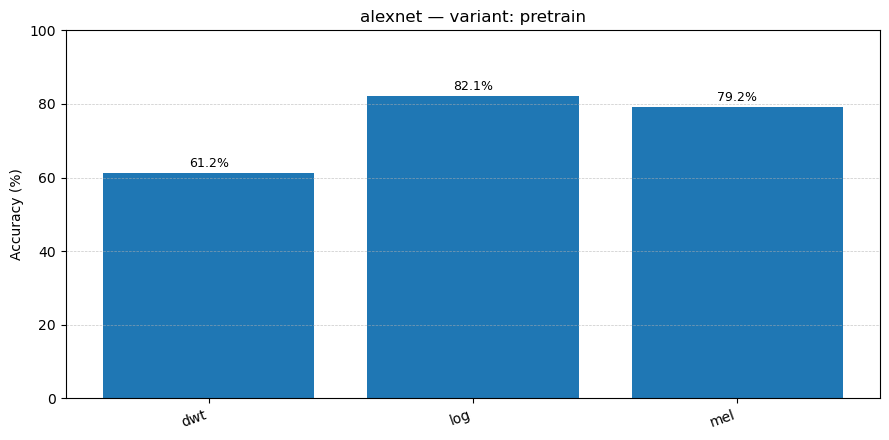

[metrics] Figure saved -> D:\UMNG-2025\FakeVoice\FakeVoice\outputs\exp_v1\reports\fig_alexnet_pretrain_accuracy.png


In [40]:
rep.plot_variants_for_model(df, model="alexnet", variant="pretrain", metric="accuracy",
                              y_min=0, y_max=100, out_name="fig_alexnet_pretrain_accuracy.png")


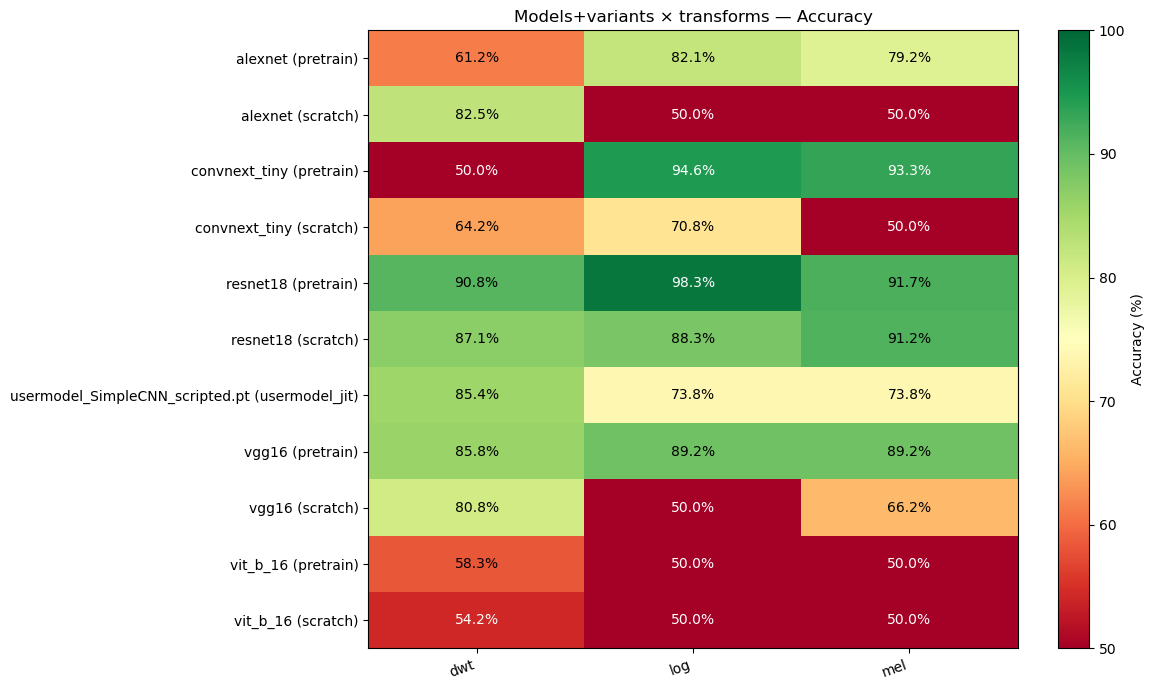

[metrics] Figure saved -> D:\UMNG-2025\FakeVoice\FakeVoice\outputs\exp_v1\reports\fig_all.png


In [41]:
rep.plot_heatmap_models_transforms(df, metric="accuracy", vmin=50, vmax=100,
                                   out_name="fig_all.png")
